In [16]:
import sys
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

sys.path.append('./../data/')

from fetch_data import FetchData


current_date = datetime.now().date()
current_date_str = current_date.strftime('%Y-%m-%d')

SYMBOL = 'AAPL'
START = '2012-01-01'
END = '2023-10-25'

data_df = FetchData(SYMBOL, start_date=START, end_date=END).fetch_data()
data_df


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.466094,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.533086,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.672230,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.804701,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.784389,394024400
...,...,...,...,...,...,...
2023-10-18,175.580002,177.580002,175.110001,175.839996,175.839996,54764400
2023-10-19,176.039993,177.839996,175.190002,175.460007,175.460007,59302900
2023-10-20,175.309998,175.419998,172.639999,172.880005,172.880005,64189300


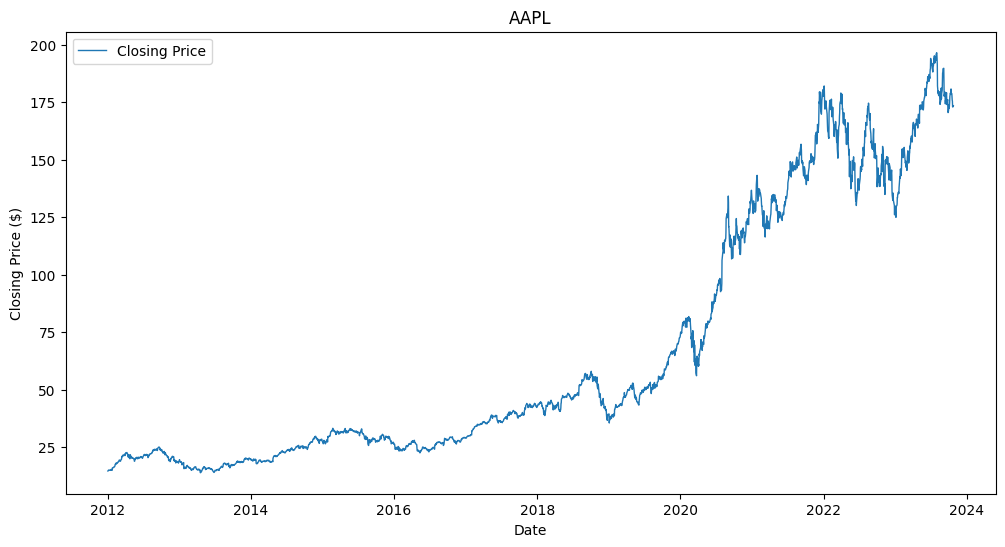

In [2]:
plt.figure(figsize=(12, 6))
plt.plot(data_df['Close'], label='Closing Price', lw=1)
plt.xlabel('Date')
plt.ylabel('Closing Price ($)')
plt.title('AAPL')
plt.legend()

plt.show()

In [3]:
missing_value_columns = []
for column in data_df.columns:
    if data_df[column].isna().any():
        missing_value_columns.append(column)

if len(missing_value_columns) > 0:
    for column in missing_value_columns:
        data_df[column] = data_df[column].fillna(data_df[column].mean(), inplace=True)

In [4]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0,1))
data_df['Close'] = scaler.fit_transform(data_df[['Close']])

In [5]:
def create_sequences(data, sequence_length):
    sequences, targets = [], []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        targets.append(data[i+sequence_length])
    return np.array(sequences), np.array(targets)

In [6]:
sequence_length = 10

In [7]:
X, y = create_sequences(data_df[['Close']].values, sequence_length)

In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

In [9]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50
65/65 [==============================] - 1s 4ms/step - loss: 0.0038 - val_loss: 0.0044
Epoch 2/50
65/65 [==============================] - 0s 2ms/step - loss: 5.6738e-05 - val_loss: 0.0010
Epoch 3/50
65/65 [==============================] - 0s 2ms/step - loss: 4.3410e-05 - val_loss: 8.6957e-04
Epoch 4/50
65/65 [==============================] - 0s 2ms/step - loss: 4.3105e-05 - val_loss: 8.0850e-04
Epoch 5/50
65/65 [==============================] - 0s 2ms/step - loss: 4.2501e-05 - val_loss: 8.5764e-04
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 4.8890e-05 - val_loss: 7.8398e-04
Epoch 7/50
65/65 [==============================] - 0s 2ms/step - loss: 4.3771e-05 - val_loss: 8.1094e-04
Epoch 8/50
65/65 [==============================] - 0s 2ms/step - loss: 4.3073e-05 - val_loss: 7.8960e-04
Epoch 9/50
65/65 [==============================] - 0s 2ms/step - loss: 4.2638e-05 - val_loss: 7.8080e-04
Epoch 10/50
65/65 [==============================] - 0s 2m

In [11]:
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)
train_data_original = scaler.inverse_transform(data_df[['Close']].values[-len(y_test) - len(y_train):-len(y_test)])

14/14 [==============================] - 0s 867us/step


In [12]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 10.711004117005642


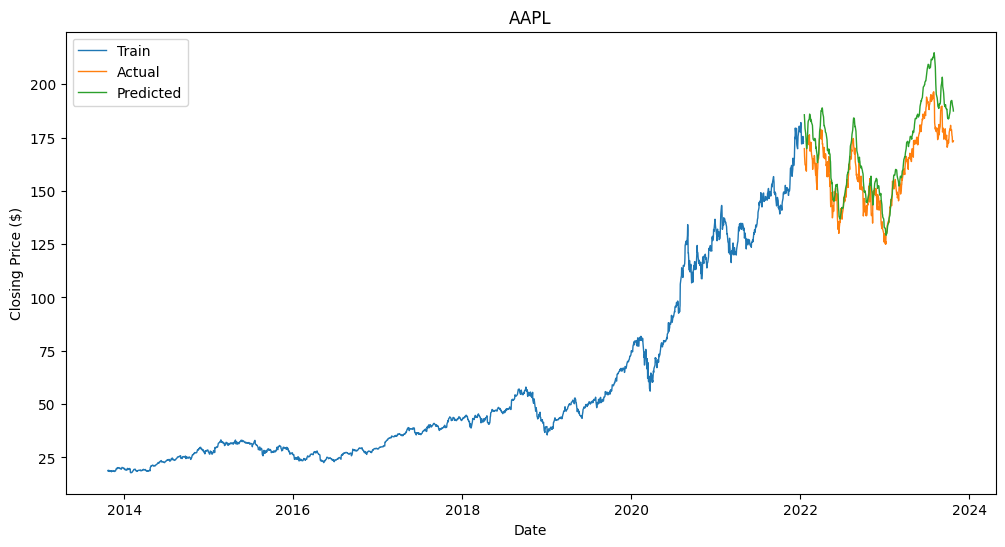

In [14]:
fig = plt.figure(figsize=(12, 6))
plt.plot(data_df.index[-len(y_test) - len(y_train):-len(y_test)], train_data_original, label='Train', lw=1)
plt.plot(data_df.index[-len(y_test):], y_test, label='Actual',lw=1)
plt.plot(data_df.index[-len(y_test):], y_pred, label='Predicted',lw=1)
plt.xlabel('Date')
plt.ylabel('Closing Price ($)')
plt.title('AAPL')
plt.legend()
plt.show()
